ECE 9063 Data Analytics Project

In [33]:
!pip install -q -U keras-tuner

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import IPython
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from joblib import dump, load

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set Random Seeds

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

Importing Data

In [36]:
# ============== Importing data ======================
featureFile = 'combined_data.csv'
featureData = pd.read_csv(featureFile)

labelFile = 'SyedHouse-GreenButton-2018-07-01-2020-02-29.csv'
labelData = pd.read_csv(labelFile)

# put feature and label in one object
data = pd.concat([featureData, labelData['Usage (kilowatt-hours)']], axis=1)
data

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Usage (kilowatt-hours)
0,-81.15,43.03,LONDON A,6144473,2018-07-01 00:00,2018,7,1,00:00,25.0,NaN,20.9,NaN,78.0,NaN,21.0,NaN,10.0,NaN,24.1,NaN,98.35,NaN,33.0,NaN,NaN,NaN,NaN,3.53
1,-81.15,43.03,LONDON A,6144473,2018-07-01 01:00,2018,7,1,01:00,23.5,NaN,20.8,NaN,84.0,NaN,20.0,NaN,7.0,NaN,24.1,NaN,98.39,NaN,32.0,NaN,NaN,NaN,Clear,3.45
2,-81.15,43.03,LONDON A,6144473,2018-07-01 02:00,2018,7,1,02:00,22.9,NaN,20.6,NaN,86.0,NaN,19.0,NaN,5.0,NaN,24.1,NaN,98.39,NaN,31.0,NaN,NaN,NaN,NaN,3.36
3,-81.15,43.03,LONDON A,6144473,2018-07-01 03:00,2018,7,1,03:00,19.9,NaN,19.3,NaN,96.0,NaN,0.0,NaN,1.0,NaN,24.1,NaN,98.42,NaN,NaN,NaN,NaN,NaN,NaN,2.90
4,-81.15,43.03,LONDON A,6144473,2018-07-01 04:00,2018,7,1,04:00,20.1,NaN,19.6,NaN,97.0,NaN,26.0,NaN,5.0,NaN,24.1,NaN,98.38,NaN,27.0,NaN,NaN,NaN,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,-81.15,43.03,LONDON A,6144473,2020-02-29 19:00,2020,2,29,19:00,-6.7,NaN,-11.7,NaN,68.0,NaN,24.0,NaN,11.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-12.0,NaN,Mainly Clear,0.84
14612,-81.15,43.03,LONDON A,6144473,2020-02-29 20:00,2020,2,29,20:00,-7.0,NaN,-11.5,NaN,71.0,NaN,23.0,NaN,11.0,NaN,24.1,NaN,98.53,NaN,NaN,NaN,-12.0,NaN,NaN,0.88
14613,-81.15,43.03,LONDON A,6144473,2020-02-29 21:00,2020,2,29,21:00,-7.1,NaN,-11.2,NaN,73.0,NaN,20.0,NaN,9.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-11.0,NaN,NaN,0.98
14614,-81.15,43.03,LONDON A,6144473,2020-02-29 22:00,2020,2,29,22:00,-9.1,NaN,-12.0,NaN,80.0,NaN,20.0,NaN,8.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-13.0,NaN,Clear,0.93


<Figure size 720x360 with 0 Axes>

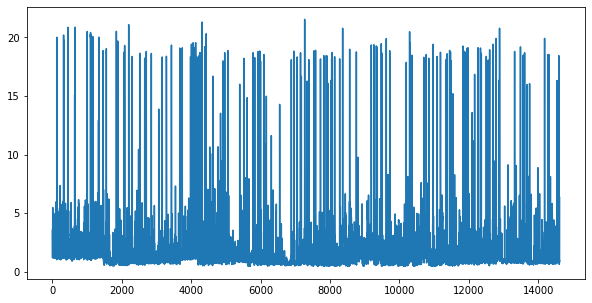

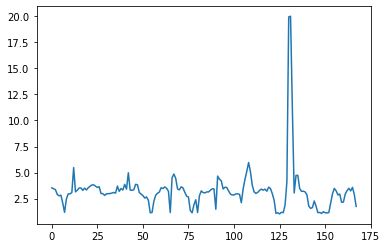

In [37]:
plt.figure(figsize=(10,5))
plt.plot(data['Usage (kilowatt-hours)'])
plt.show()

# close up on the first week
plt.plot(data['Usage (kilowatt-hours)'].head(168))
plt.show()

Data Cleaning

In [38]:
# ================= Data Cleaning =======================

# drop the columns with mostly missing values
data = data.drop(columns=["Temp Flag", "Dew Point Temp Flag", "Rel Hum Flag", "Wind Dir Flag", "Wind Spd Flag",
                   "Visibility Flag", "Stn Press Flag", "Hmdx", "Hmdx Flag", "Wind Chill", "Wind Chill Flag"])

# drop columns with constant data
data = data.drop(columns=["Longitude (x)", "Latitude (y)", "Station Name", "Climate ID", 'Date/Time'])

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    9
Dew Point Temp (°C)          9
Rel Hum (%)                  9
Wind Dir (10s deg)          19
Wind Spd (km/h)              9
Visibility (km)              8
Stn Press (kPa)              9
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


In [39]:
# Deal with missing values
columns_to_clean = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
                    "Visibility (km)", "Stn Press (kPa)"]

# replace with previous hour data
for col in columns_to_clean:
    data[col].fillna(method='ffill', inplace=True)
    data[col].fillna(method='bfill', inplace=True)

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


Weather Attribute

In [40]:
# clean the "weather" attribute: replace missing values with previous observations
data["Weather"].fillna(method='ffill', inplace=True)
data["Weather"].fillna(method='bfill', inplace=True)

print(data.isnull().sum())

Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)                 0
Dew Point Temp (°C)       0
Rel Hum (%)               0
Wind Dir (10s deg)        0
Wind Spd (km/h)           0
Visibility (km)           0
Stn Press (kPa)           0
Weather                   0
Usage (kilowatt-hours)    0
dtype: int64


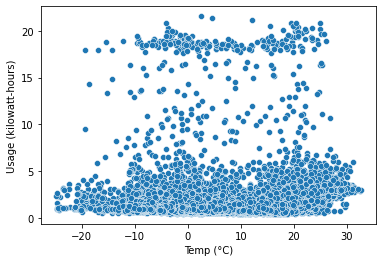

In [41]:
sns.scatterplot(data=data, x="Temp (°C)", y="Usage (kilowatt-hours)")

Hour of Day

In [42]:
data['Time'] = data['Time'].apply(lambda s: float(s.split(':')[0]))
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours)
0,2018,7,1,0.0,25.0,20.9,78.0,21.0,10.0,24.1,98.35,Clear,3.53
1,2018,7,1,1.0,23.5,20.8,84.0,20.0,7.0,24.1,98.39,Clear,3.45
2,2018,7,1,2.0,22.9,20.6,86.0,19.0,5.0,24.1,98.39,Clear,3.36
3,2018,7,1,3.0,19.9,19.3,96.0,0.0,1.0,24.1,98.42,Clear,2.90
4,2018,7,1,4.0,20.1,19.6,97.0,26.0,5.0,24.1,98.38,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84
14612,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88
14613,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98
14614,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93


Day of week

In [43]:
# 2018.7.1 Sunday, 2020.2.29 Saturday

day_week = []
counter = 0

for day in range(len(data)):
  if 0<= counter <= 23:
    day_week.append(7)
  elif 24 <= counter <=47:
    day_week.append(1)
  elif 48<= counter <= 71:
    day_week.append(2)
  elif 72 <= counter <= 95:
    day_week.append(3)
  elif 96 <= counter <=119:
    day_week.append(4)
  elif 120 <=counter <= 143:
    day_week.append(5)
  elif 144 <= counter <=167:
    day_week.append(6)
  
  counter += 1

  if counter > 167:
    counter = 0

day_week = pd.DataFrame(data=day_week, columns=['day_week'])
day_week

data = pd.concat([data, day_week], axis=1)

,day_week
0,7
1,7
2,7
3,7
4,7
...,...
14611,6
14612,6
14613,6
14614,6


Usage at previous timesteps as features

In [44]:
steps = 7

for i in range(1,steps):
  data['Previous_Usage' + str(i)] = data['Usage (kilowatt-hours)'].shift(i)
  
for i in range(steps-1):
  data.drop(index=i, inplace=True)

data = pd.DataFrame.reset_index(data, drop=True)
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours),day_week,Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6
0,2018,7,1,6.0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,Mainly Clear,2.08,7,2.83,2.77,2.90,3.36,3.45,3.53
1,2018,7,1,7.0,24.8,21.8,83.0,19.0,9.0,24.1,98.43,Mainly Clear,1.18,7,2.08,2.83,2.77,2.90,3.36,3.45
2,2018,7,1,8.0,26.6,22.7,79.0,18.0,9.0,24.1,98.44,Mainly Clear,2.46,7,1.18,2.08,2.83,2.77,2.90,3.36
3,2018,7,1,9.0,28.2,23.4,75.0,18.0,14.0,24.1,98.46,Mainly Clear,2.95,7,2.46,1.18,2.08,2.83,2.77,2.90
4,2018,7,1,10.0,29.4,23.7,71.0,17.0,14.0,24.1,98.42,Mainly Clear,2.96,7,2.95,2.46,1.18,2.08,2.83,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84,6,0.87,0.71,0.83,0.67,0.86,0.82
14606,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88,6,0.84,0.87,0.71,0.83,0.67,0.86
14607,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98,6,0.88,0.84,0.87,0.71,0.83,0.67
14608,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93,6,0.98,0.88,0.84,0.87,0.71,0.83


Season Feature

In [45]:
season = []
for month in data['Month']:
  if 4 <= month <= 5:
    season.append(1)
  elif 6 <= month <= 9:
    season.append(2)
  elif 10 <= month <= 11:
    season.append(3)
  elif 12 == month or month <= 3:
    season.append(4)

season = pd.DataFrame(data=season, columns=['Season'])
season

data = pd.concat([data, season], axis=1)

,Season
0,2
1,2
2,2
3,2
4,2
...,...
14605,4
14606,4
14607,4
14608,4


Unit Circle Mapping for Cyclical Features

In [46]:
def encode_cyclical(data, col, max_val):
  data[col + '_sin'] = np.sin(2*np.pi*data[col]/max_val)
  data[col + '_cos'] = np.cos(2*np.pi*data[col]/max_val)

  data.drop(columns=[col], inplace=True)
  return data


data = encode_cyclical(data, 'Month', 12)
data = encode_cyclical(data, 'Time', 24)
data = encode_cyclical(data, 'day_week', 7)
data = encode_cyclical(data, 'Season', 4)

One-hot Encoding for Categorical Attributes

In [47]:
#data_onehot = pd.get_dummies(data, columns=['Weekend'])

data_onehot = data.copy()

# Discard Weather and Year feature
data_onehot = data_onehot.drop(columns=['Weather', 'Year', 'Day'], axis=1)

data_onehot

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Usage (kilowatt-hours),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,day_week_sin,day_week_cos,Season_sin,Season_cos
0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,2.08,2.83,2.77,2.90,3.36,3.45,3.53,-0.500000,-0.866025,1.000000,6.123234e-17,-2.449294e-16,1.00000,1.224647e-16,-1.0
1,24.8,21.8,83.0,19.0,9.0,24.1,98.43,1.18,2.08,2.83,2.77,2.90,3.36,3.45,-0.500000,-0.866025,0.965926,-2.588190e-01,-2.449294e-16,1.00000,1.224647e-16,-1.0
2,26.6,22.7,79.0,18.0,9.0,24.1,98.44,2.46,1.18,2.08,2.83,2.77,2.90,3.36,-0.500000,-0.866025,0.866025,-5.000000e-01,-2.449294e-16,1.00000,1.224647e-16,-1.0
3,28.2,23.4,75.0,18.0,14.0,24.1,98.46,2.95,2.46,1.18,2.08,2.83,2.77,2.90,-0.500000,-0.866025,0.707107,-7.071068e-01,-2.449294e-16,1.00000,1.224647e-16,-1.0
4,29.4,23.7,71.0,17.0,14.0,24.1,98.42,2.96,2.95,2.46,1.18,2.08,2.83,2.77,-0.500000,-0.866025,0.500000,-8.660254e-01,-2.449294e-16,1.00000,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,0.84,0.87,0.71,0.83,0.67,0.86,0.82,0.866025,0.500000,-0.965926,2.588190e-01,-7.818315e-01,0.62349,-2.449294e-16,1.0
14606,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,0.88,0.84,0.87,0.71,0.83,0.67,0.86,0.866025,0.500000,-0.866025,5.000000e-01,-7.818315e-01,0.62349,-2.449294e-16,1.0
14607,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,0.98,0.88,0.84,0.87,0.71,0.83,0.67,0.866025,0.500000,-0.707107,7.071068e-01,-7.818315e-01,0.62349,-2.449294e-16,1.0
14608,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,0.93,0.98,0.88,0.84,0.87,0.71,0.83,0.866025,0.500000,-0.500000,8.660254e-01,-7.818315e-01,0.62349,-2.449294e-16,1.0


Data Preprocessing

In [48]:
df = data_onehot.copy()

# split into 60%:20%:20%
n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

# save the scaling of target variable
y_mean = train_df['Usage (kilowatt-hours)'].mean()
y_std = train_df['Usage (kilowatt-hours)'].std()

ori_y_train = train_df['Usage (kilowatt-hours)'].to_numpy().copy()
ori_y_test = test_df['Usage (kilowatt-hours)'].to_numpy().copy()

# standardization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Avoid scaling on one-hot and unit-mapped features

# scale_cols = ['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 
#               'Wind Dir (10s deg)', 'Wind Spd (km/h)',
#               'Visibility (km)', 'Stn Press (kPa)', 'Usage (kilowatt-hours)']


# for col in scale_cols:
#   scalerX = StandardScaler().fit(train_df[[col]])
#   train_df[col] = scalerX.transform(train_df[[col]])
#   val_df[col] = scalerX.transform(val_df[[col]])
#   test_df[col] = scalerX.transform(test_df[[col]])


Sliding Window

In [49]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [50]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [51]:
def plot(self, model=None, plot_col='Usage (kilowatt-hours)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  #plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [52]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [53]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Modeling

In [54]:
steps = 1
OUT_STEPS = 1

window = WindowGenerator(
    input_width=steps, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['Usage (kilowatt-hours)'])
window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Usage (kilowatt-hours)']

In [55]:
# ========================= Hyper-parameters Tuning ==============================

# def build_model(hp):
#     model = keras.models.Sequential()

#     # Hyper-parameters
#     hp_units = hp.Choice('units', values=[30, 60])
#     hp_layers = hp.Choice('layers', values=[2, 3, 4, 5])

#     # input layer
#     model.add(layers.Flatten())
#     model.add(layers.Dense(units=num_features, activation='elu', kernel_initializer='he_normal'))

#     # hidden layers
#     for layer in range(hp_layers):
#         model.add(layers.Dense(units=hp_units, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)))

#     # output layer
#     model.add(layers.Dense(1, kernel_initializer='he_normal'))

#     model.add(layers.Reshape([1, -1]))

#     optimizer = keras.optimizers.Nadam()
#     model.compile(loss='mse', optimizer=optimizer)
#     return model


# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, mode='min')

# tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10, seed=42)

# tuner.search(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])


In [56]:
# Retain the optimal hyper-parameters found and re-train the model

# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# model = tuner.hypermodel.build(best_hps)

# history = model.fit(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])

In [57]:
model = tf.keras.Sequential([                    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=num_features, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(units=30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dense(units=30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dense(units=30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dense(units=1, kernel_initializer='he_normal'),
    tf.keras.layers.Reshape([1,-1]),
])


model.compile(loss='mse', optimizer='Nadam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=False, mode='min')

history = model.fit(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])

model.summary()

Epoch 1/100
274/274 [==============================] - 1s 5ms/step - loss: 3.9744 - root_mean_squared_error: 0.9424 - val_loss: 3.0829 - val_root_mean_squared_error: 0.7397
Epoch 2/100
274/274 [==============================] - 1s 5ms/step - loss: 2.6320 - root_mean_squared_error: 0.7389 - val_loss: 2.2158 - val_root_mean_squared_error: 0.7267
Epoch 3/100
274/274 [==============================] - 1s 4ms/step - loss: 1.9010 - root_mean_squared_error: 0.7211 - val_loss: 1.6307 - val_root_mean_squared_error: 0.7199
Epoch 4/100
274/274 [==============================] - 1s 5ms/step - loss: 1.4213 - root_mean_squared_error: 0.7161 - val_loss: 1.2421 - val_root_mean_squared_error: 0.7150
Epoch 5/100
274/274 [==============================] - 1s 5ms/step - loss: 1.1095 - root_mean_squared_error: 0.7152 - val_loss: 0.9977 - val_root_mean_squared_error: 0.7173
Epoch 6/100
274/274 [==============================] - 1s 5ms/step - loss: 0.9070 - root_mean_squared_error: 0.7139 - val_loss: 0.8372 

Plot Loss vs Epochs

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

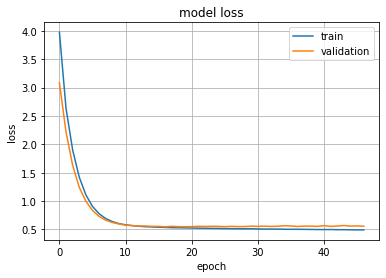

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

Accuracy & Evaluation

In [59]:
ori_y_train = ori_y_train[steps:]
ori_y_test = ori_y_test[steps:]

(8765, 1, 1)
(8765,)
(8765,)
[1.2077656 0.8952205 1.7908692 ... 1.5879462 1.1444883 1.6463231]


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in train set')

Text(0, 0.5, 'Consumption')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

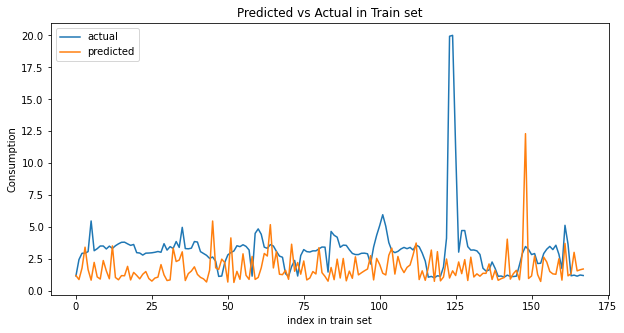

In [60]:
# train set performance
Y_train_pred_scaled = model.predict(window.train)
print(np.shape(Y_train_pred_scaled))

Y_train_pred = Y_train_pred_scaled[:, -1, 0];

print(Y_train_pred.shape)
print(ori_y_train.shape)

# scale back
Y_train_pred = Y_train_pred * y_std + y_mean

print(Y_train_pred)

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(ori_y_train[:168], label='actual')
plt.plot(Y_train_pred[:168], label='predicted')
plt.xlabel('index in train set')
plt.ylabel('Consumption')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()

(2921, 1, 1)
(2921,)
(2921,)
[1.92153    1.133354   0.978037   ... 0.89004016 0.86394215 1.164835  ]


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'index in test set')

Text(0, 0.5, 'Consumption')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

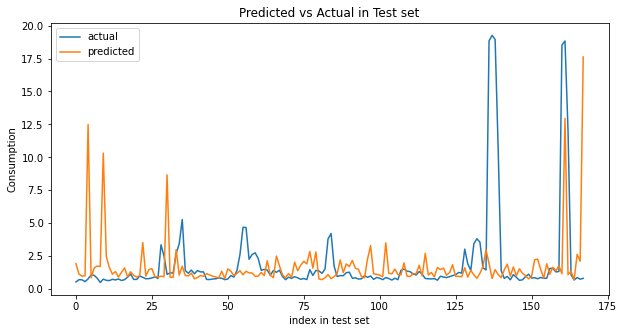

In [61]:
# test set performance
Y_test_pred_scaled = model.predict(window.test)
print(np.shape(Y_test_pred_scaled))

Y_test_pred = Y_test_pred_scaled[:, -1, 0]

print(Y_test_pred.shape)
print(ori_y_test.shape)

# scale back
Y_test_pred = Y_test_pred * y_std + y_mean

print(Y_test_pred)


# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(ori_y_test[:168], label='actual')
plt.plot(Y_test_pred[:168], label='predicted')
plt.xlabel('index in test set')
plt.ylabel('Consumption')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

In [62]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

In [63]:
# Error Metric summary
model_performance = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])

Train_MAE = mean_absolute_error(ori_y_train, Y_train_pred).round(2)
Train_RMSE = np.sqrt(mean_squared_error(ori_y_train, Y_train_pred)).round(2)
train_mape = mape(ori_y_train, Y_train_pred).numpy().round(2)
print(train_mape)

Test_MAE = mean_absolute_error(ori_y_test, Y_test_pred).round(2)
Test_RMSE = np.sqrt(mean_squared_error(ori_y_test, Y_test_pred)).round(2)
test_mape = mape(ori_y_test, Y_test_pred).numpy().round(2)
print(test_mape)

model_performance = model_performance.append({
                        'Train MAE': Train_MAE,
                        'Train RMSE': Train_RMSE,
                        'Test MAE': Test_MAE,
                        'Test RMSE': Test_RMSE},
                        ignore_index=True)

model_performance

95.21
75.05


,Train MAE,Train RMSE,Test MAE,Test RMSE
0,1.54,3.18,1.3,3.13
